In [212]:
# Importing useful libraries
import pandas as pd 

In [213]:
df2 = pd.read_csv("results.csv", encoding = "ISO-8859-1")
df2.head()

,Season,DateTime,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,1993-94,1993-08-14T00:00:00Z,Arsenal,Coventry,0,3,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-94,1993-08-14T00:00:00Z,Aston Villa,QPR,4,1,H,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-94,1993-08-14T00:00:00Z,Chelsea,Blackburn,1,2,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-94,1993-08-14T00:00:00Z,Liverpool,Sheffield Weds,2,0,H,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-94,1993-08-14T00:00:00Z,Man City,Leeds,1,1,D,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='Numer of Matches', ylabel='Season'>

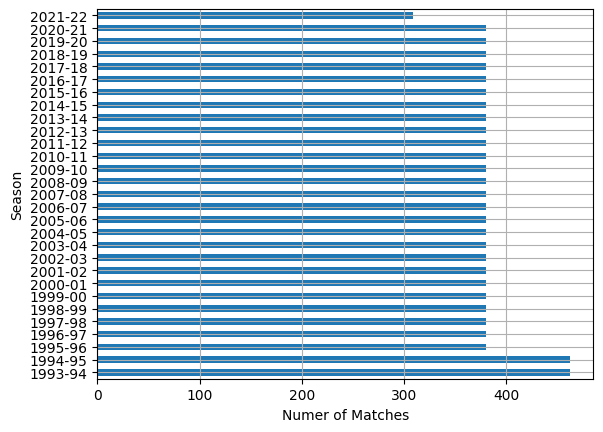

In [214]:
df2["Season"].value_counts().sort_index().plot(kind='barh',grid=1,xlabel='Numer of Matches')

The EPL had 22 teams in the seasons 1993-94 and 1994-95, which explains the differences in the number of matches with respect to other seasons. Season 2021-22 is not complete.

<Axes: xlabel='Numer of Home Matches', ylabel='HomeTeam'>

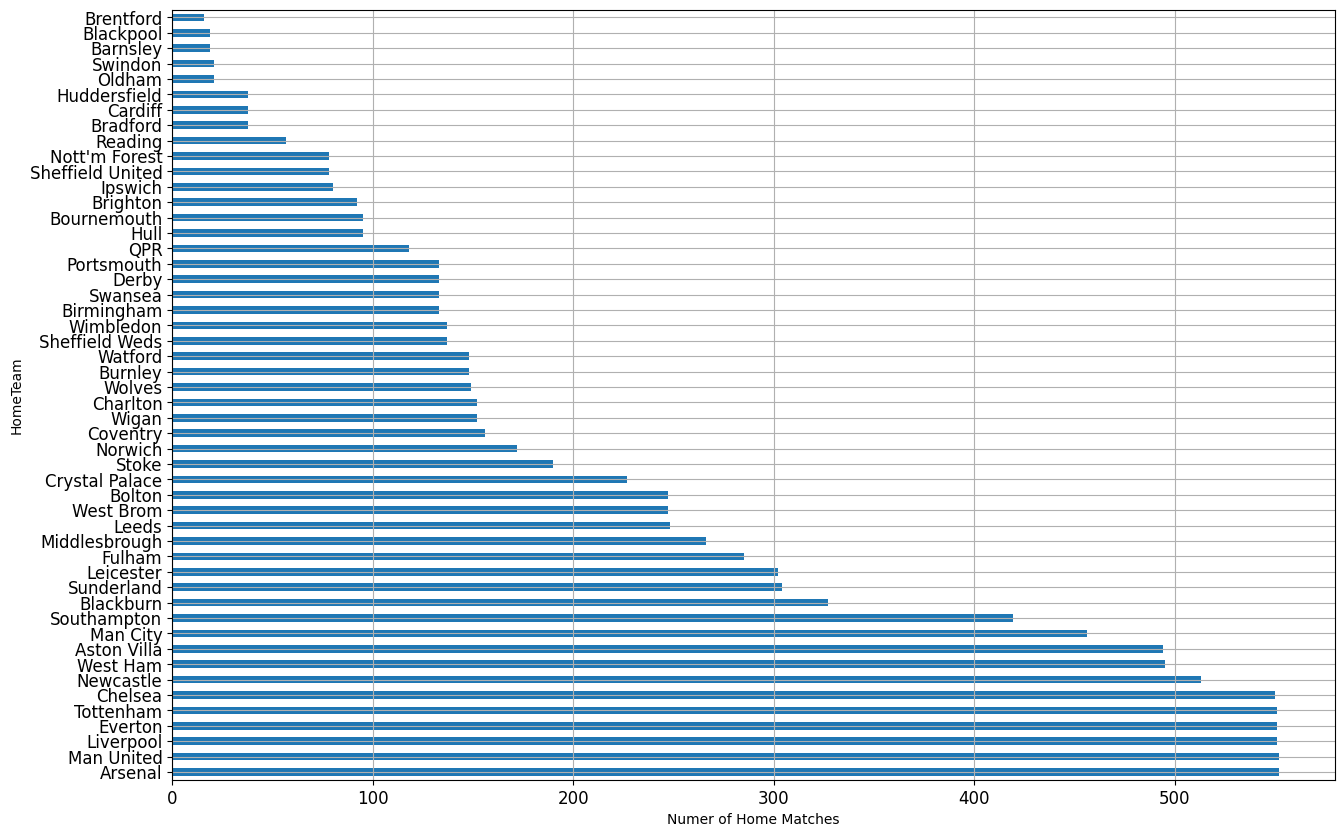

In [215]:
df2['HomeTeam'].sort_index().value_counts().plot(kind='barh',grid=1,xlabel='Numer of Home Matches',width=0.5, fontsize=12,figsize=(15,10))

<Axes: xlabel='Numer of Away Matches', ylabel='AwayTeam'>

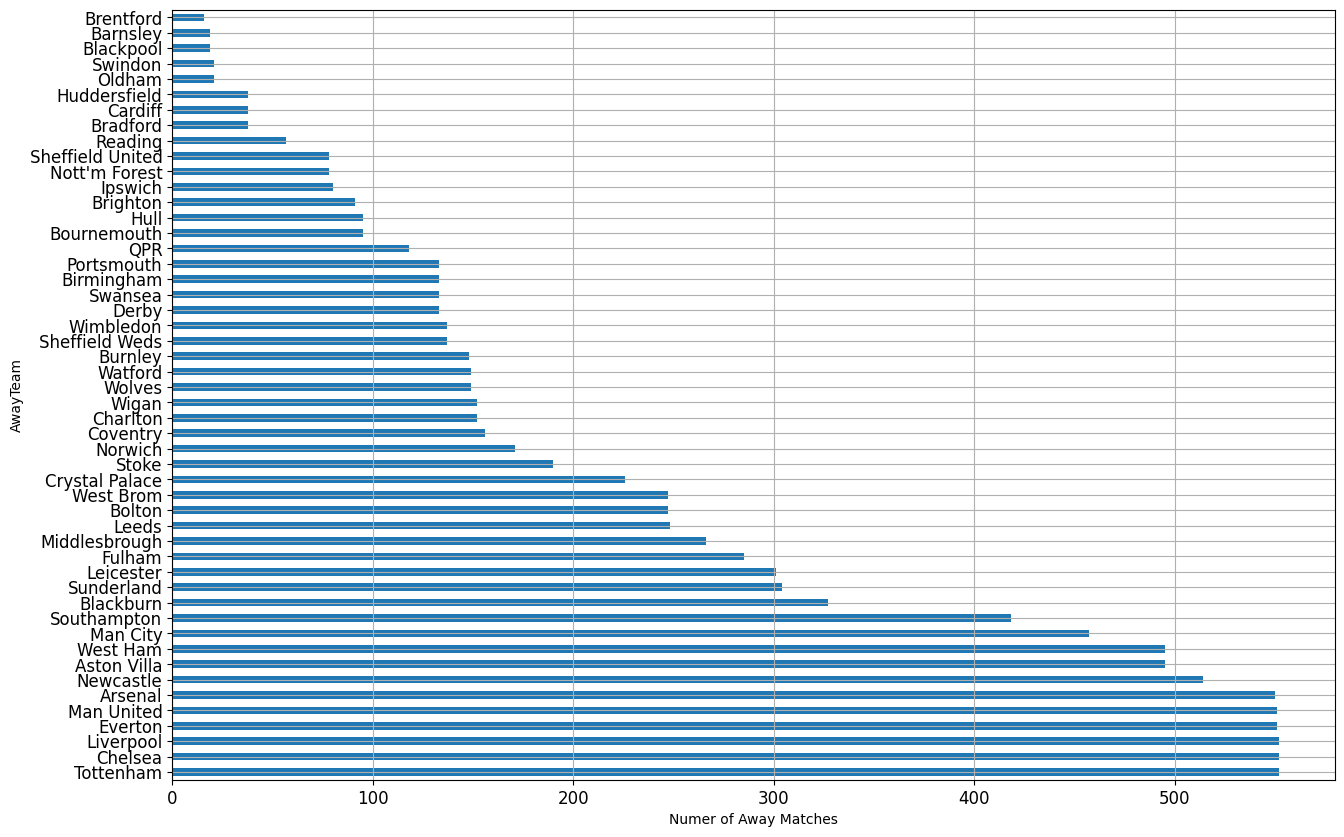

In [216]:
df2['AwayTeam'].sort_index().value_counts().plot(kind='barh',grid=1,xlabel='Numer of Away Matches',width=0.5, fontsize=12,figsize=(15,10))

<Axes: xlabel='Goals'>

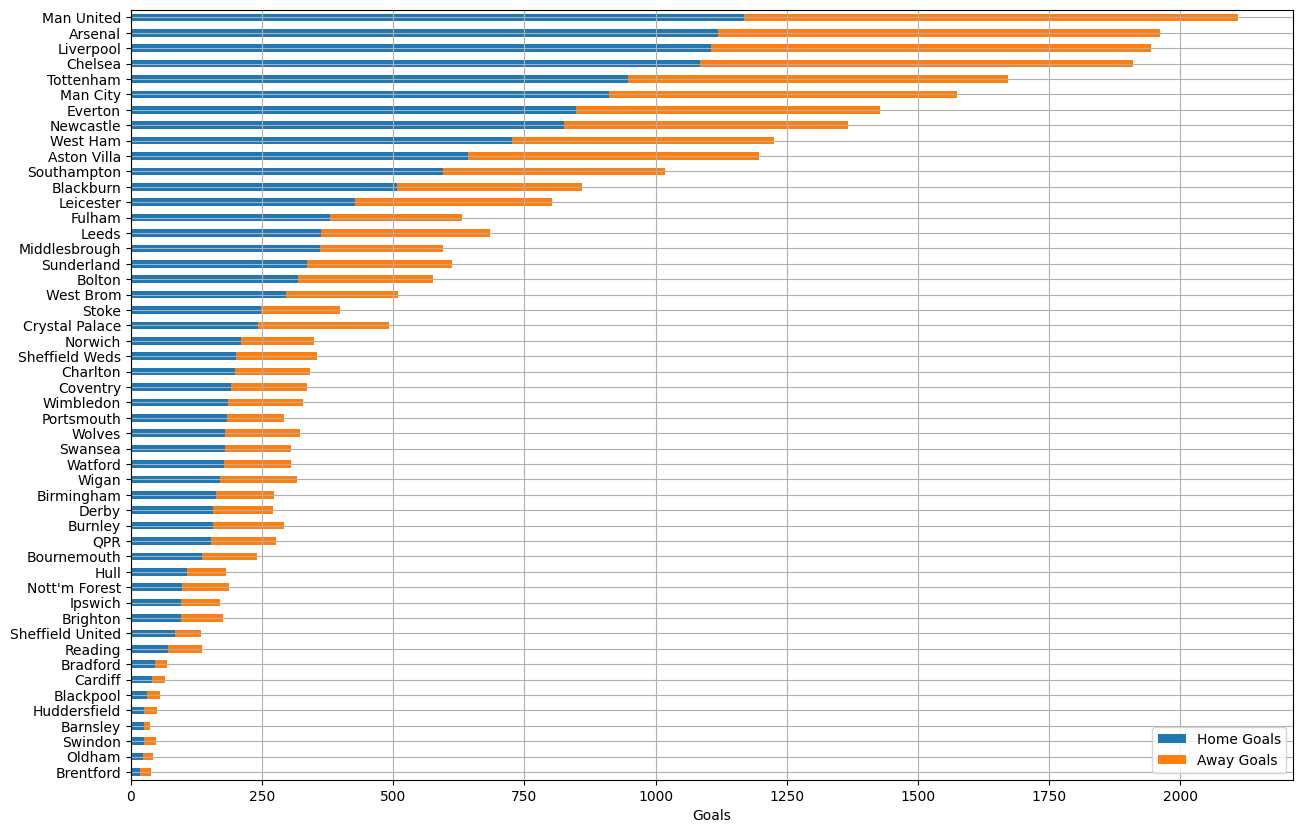

In [217]:
goalsA = df2.groupby(["AwayTeam"]).FTAG.sum().sort_values().to_frame('Away Goals')
#plot(kind='barh',grid=1,xlabel='Numer of Away Matches',width=0.5, fontsize=12,figsize=(20,13))
TotalGoals =  df2.groupby(["HomeTeam"]).FTHG.sum().sort_values().to_frame('Home Goals').merge(goalsA, left_index=True,right_index = True,how='outer')
TotalGoals.sort_values(by=['Home Goals']).plot(kind='barh',grid=1,xlabel='Goals',stacked=True,legend=['Home','Away'],figsize=(15,10))

<Axes: xlabel='Wins'>

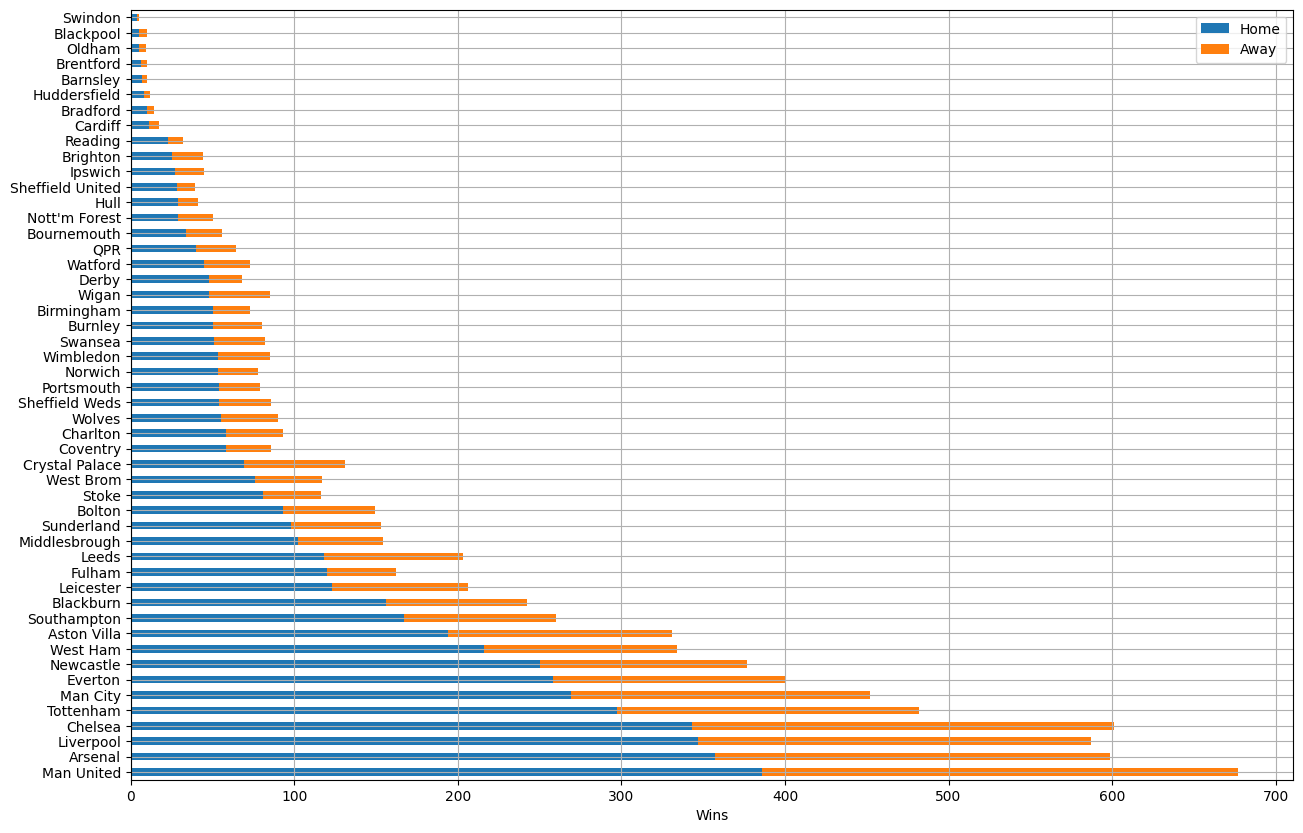

In [218]:
maskH = df2["FTR"]=='H'
maskA = df2["FTR"]=='A'
maskD = df2["FTR"]=='D'

# df2.groupby(["HomeTeam"]).FTR.sum()
AwayWins = df2[maskA]["AwayTeam"].value_counts().to_frame('Away')
wins = df2[maskH]["HomeTeam"].value_counts().to_frame('Home').merge(AwayWins, left_index=True,right_index = True,how='outer')
wins.sort_values(by=['Home'],ascending=False).plot(kind='barh',grid=1,xlabel='Wins',stacked=True,figsize=(15,10))


In [219]:
df2.dtypes
df2["DateTime"]= pd.to_datetime(df2["DateTime"])

In [220]:
# Getting dummy variables for the venue column 
team_dummies = pd.get_dummies(df2[["HomeTeam",'AwayTeam']])
df2["home_code"] = df2["HomeTeam"].astype("category").cat.codes
df2["away_code"] = df2["AwayTeam"].astype("category").cat.codes
df2["day_code"]  = df2["DateTime"].dt.dayofweek
df2["HTR_code"] = (df2["HTR"] == "H").astype("int")

In [222]:
df2["home_win"] = (df2["FTR"] == "H").astype("int")
df2["away_win"] = (df2["FTR"] == "A").astype("int")

# df2["home_draw"] = (df2["FTR"] == "D").astype("int")
# df2["away_draw"] = (df2["FTR"] == "D").astype("int")

In [223]:
def rolling_averages(group, cols, new_cols,win):
    group = group.sort_values("DateTime")
    rolling_stats = group[cols].rolling(win, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    # group = group.fillna(0)
    return group

In [226]:
cols = [ "FTHG","FTAG",'HS', 'AS', 'HST', 'AST', 'HC', 'AC',
       'HF', 'AF', 'HY', 'AY', 'HR', 'AR','home_win']
new_cols = [f"{c}_rolling" for c in cols]
cols_away = [ 'away_win']
new_cols_away = [f"{c}_rolling" for c in cols_away]

In [230]:
df_rolling = df2.groupby("HomeTeam").apply(lambda x: rolling_averages(x,cols,new_cols,5))
df_rolling_away = df2.groupby("AwayTeam").apply(lambda x: rolling_averages(x,cols_away,new_cols_away,5))
df_rolling = df_rolling.droplevel('HomeTeam').sort_index()
df_rolling_away = df_rolling_away.droplevel('AwayTeam').sort_index()
df_rolling['away_win_rolling'] = df_rolling_away['away_win_rolling']
# group = df_rolling[df_rolling["AwayTeam"]=='Arsenal'][0:40]
df_rolling_away[df_rolling_away["AwayTeam"]=='Arsenal'][0:40]
# df_rolling
df_rolling[df_rolling['away_win_rolling'].isna()==1] = df_rolling[df_rolling['away_win_rolling'].isna()==1].fillna(0)

In [257]:
features = ['DateTime','day_code','HTR_code'] + new_cols + new_cols_away
X = pd.concat([df_rolling[features], team_dummies], axis=1)
y = df2['FTR']
X.columns

idx_train = (X["DateTime"] < '2020-01-01') & (X["DateTime"] > '2001-01-01')
idx_test = X["DateTime"] > '2020-01-01'
X.drop(['DateTime'], axis=1, inplace=True)
X_train = X[idx_train]
X_test = X[idx_test]
y_train = y[idx_train]
y_test = y[idx_test]

In [252]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,classification_report

In [264]:
rf = RandomForestClassifier(n_estimators=50,min_samples_split=10,random_state=1)

In [265]:
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
report = classification_report(y_test,y_pred)
print(cm)
print(report)

[[221  36  51]
 [ 97  26  75]
 [ 67  19 273]]
              precision    recall  f1-score   support

           A       0.57      0.72      0.64       308
           D       0.32      0.13      0.19       198
           H       0.68      0.76      0.72       359

    accuracy                           0.60       865
   macro avg       0.53      0.54      0.51       865
weighted avg       0.56      0.60      0.57       865

